<div class="alert alert-block alert-warning">
    <div style="font-size: 40px; font-weight: bold;">Comparison: RF vs MDS</div>    
    <b>NOTE</b>: This run uses a reduced dataset for the comparison to MDS: the RF in this notebook uses the same data basis and the same variables like in the MDS run.
</div>

# Setup

## Imports

In [1]:
import os
import datetime as dt

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 99)
pd.set_option('display.max_rows', 99)

import warnings
warnings.filterwarnings('ignore')

from pkgs.randomforest_ts import RandomForestTS  # From DIIVE

In [2]:
print(f"Working directory: {os.getcwd()}")

Working directory: /home/jovyan/work/ms-ch-aes/notebooks


## Load MDS data from file
Load the original data file.

In [4]:
DATAFILE = "/home/jovyan/work/ms-ch-aes/data/ch-aes-fluxes-co2-n2o-ch4-and-meteo-2019-2020/CH-AES_2019_2020_data_for_analysis_20211130.csv"
date_parser = lambda c: pd.to_datetime(c, format='%Y-%m-%d %H:%M:%S', errors='coerce')
source_df = pd.read_csv(DATAFILE, index_col=0, parse_dates=True, na_values=[-9999, 'NA'], date_parser=date_parser)
print(f"\nLoaded data from file <b>s</b>{DATAFILE}\n")
print(f"\nData columns with original column names:\n{list(source_df.columns)}\n\n")


Loaded data from file <b>s</b>/home/jovyan/work/ms-ch-aes/data/ch-aes-fluxes-co2-n2o-ch4-and-meteo-2019-2020/CH-AES_2019_2020_data_for_analysis_20211130.csv


Data columns with original column names:
['TA', 'RH', 'PA', 'Rg', 'TS_0.05', 'TS_0.15', 'TS_0.30', 'WFPS_0.05', 'WFPS_0.15', 'WFPS_0.30', 'PREC', 'VPD', 'NEE', 'GPP', 'Reco', 'NEE_flag01_ustar', 'NEE_flag0_ustar', 'NEE_flag0', 'NEE_flag01', 'N2O_flag01', 'N2O_flag0', 'N2O_flag0_ustar', 'CH4_flag01', 'CH4_flag0', 'CH4_flag0_ustar', 'herb', 'harvest', 'Nmin', 'Norg', 'Nfert', 'soil', 'sow', 'veg.height', 'lai', 'N2O_gfMDS', 'CH4_gfMDS', 'N2O_flag01_ustar', 'CH4_flag01_ustar']




array([<AxesSubplot:xlabel='TIMESTAMP'>, <AxesSubplot:xlabel='TIMESTAMP'>,
       <AxesSubplot:xlabel='TIMESTAMP'>], dtype=object)

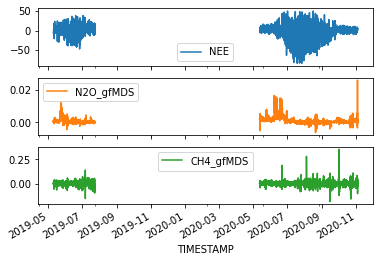

In [9]:
mds_df = source_df[['NEE', 'N2O_gfMDS', 'CH4_gfMDS']]
mds_df.plot(subplots=True)

### Sanitize original timestamp

**Check timestamp index for erroneous timestamps**:
Timestamp is checked for duplicates and timestamp NaTs ("not a time").

In [10]:
# Remove duplicates, keep first
locs_duplicates = mds_df.index.duplicated(keep='first')
print(f"Found duplicates in index: {locs_duplicates.sum()}")
mds_df = mds_df[~locs_duplicates]

# Remove NaTs
locs_nats = mds_df.index.isnull()
print(f"Found duplicates in index: {locs_nats.sum()}")
mds_df = mds_df[~locs_nats]

Found duplicates in index: 0
Found duplicates in index: 0


**Sort timestamp**: ascending order

In [12]:
# Sort timestamp index
mds_df = mds_df.sort_index(ascending=True)

### Check data

**Data description**:

In [13]:
mds_df.describe()

,NEE,N2O_gfMDS,CH4_gfMDS
count,11953.000000,11967.000000,11967.000000
mean,-1.922918,0.001116,0.001883
std,15.429920,0.001855,0.013402
min,-83.684132,-0.006171,-0.183057
25%,-5.157756,0.000252,-0.003091
50%,2.535966,0.000553,0.002209
75%,6.609504,0.001359,0.006092
max,49.584670,0.025850,0.353205


**Available values by year**:

In [14]:
mds_df.groupby(source_df.index.year).count()

,NEE,N2O_gfMDS,CH4_gfMDS
TIMESTAMP,,,
2019,3578,3550,3550
2020,8375,8417,8417


## Load RF data from files

In [25]:
rf_df = pd.read_csv('NEE_gapfilled_2020.C.1_QCF01.csv', index_col=0, parse_dates=True, na_values=[-9999, 'NA'], date_parser=date_parser, header=[0,1])
rf_df

,target,.predictions,.gap_predictions,QCF_target#gfRF,target#gfRF,.predictions_fallback,.gapfilled_cumulative
,-,[aux],[aux],[0=measured],-,[aux],[aux]
TIMESTAMP,,,,,,,
2020-05-12 16:15:00,-3.797234,-3.113689,NaN,0,-3.797234,-2.164166,-3.797234
2020-05-12 16:45:00,-3.955568,-3.242703,NaN,0,-3.955568,-2.164166,-7.752802
2020-05-12 17:15:00,-2.760091,-0.696616,NaN,0,-2.760091,-3.658819,-10.512894
2020-05-12 17:45:00,-3.204789,-1.897094,NaN,0,-3.204789,-3.658819,-13.717682
2020-05-12 18:15:00,-0.800821,0.078910,NaN,0,-0.800821,1.260092,-14.518504
...,...,...,...,...,...,...,...
2020-09-14 20:15:00,-11.686780,-4.141712,NaN,0,-11.686780,1.212559,-25044.416986
2020-09-14 20:45:00,NaN,15.216816,15.216816,1,15.216816,1.212559,-25029.200170


## Prepare work dataset
Prepare dataset with reduced number of variables.  

**Copy**: always work on a copy, the loaded original data (`source_df`) remains untouched

In [10]:
# Make a copy
df = source_df.copy()

### Select columns and range

Remove unneeded columns:

In [11]:
df = df[usecols].copy()
# df.drop(dropcols, axis=1, inplace=True)

Rename the target column to 'target':

In [12]:
# Define and rename target column
df.rename(columns={target: 'target'}, inplace=True)

Get datetime of first and last available measurement of target:

In [13]:
_first_target_value_dt = df['target'].dropna().index[0]
_last_target_value_dt = df['target'].dropna().index[-1]
print(f"First measured value of target: {_first_target_value_dt}")
print(f"Last measured value of target: {_last_target_value_dt}")
print(f"Maximum value in target: {df['target'].max()}")
print(f"Minimum value in target: {df['target'].min()}")

First measured value of target: 2019-05-10 12:45:00
Last measured value of target: 2020-11-03 07:45:00
Maximum value in target: 54.20916
Minimum value in target: -92.0534


### Convert flux units
- from `umol m-2 s-1` to `nmol m-2 s-1`:

In [14]:
factor = 1000
if not 'NEE' in target:  # Do not convert for CO2 flux
    df['target'] = df['target'].multiply(factor)  
    print(f"Multiplied {target} by {factor}")
else:
    print(f"No conversion for {target}")        

No conversion for NEE_flag01_ustar


#### Check variables in work dataset

In [15]:
df.columns

Index(['VPD', 'TA', 'Rg', 'target'], dtype='object')

In [16]:
pd.set_option('display.max_columns', 99)
pd.set_option('display.max_rows', 99)
display(df.head(3))
display(df.columns)

,VPD,TA,Rg,target
TIMESTAMP,,,,
2019-05-08 15:45:00,NaN,10.233333,45.000000,NaN
2019-05-08 16:15:00,NaN,10.100000,45.000000,NaN
2019-05-08 16:45:00,NaN,10.133333,39.666667,NaN


Index(['VPD', 'TA', 'Rg', 'target'], dtype='object')

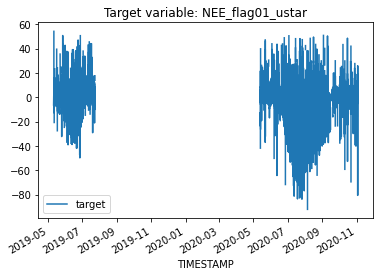

In [17]:
df[['target']].plot(title=f"Target variable: {target}");

# Random Forest

## Prepare Data Subset
Make subset of data that is used in RF.

In [18]:
# Make copy to work with
subset_df = df.copy()

In [19]:
# Select year
subset_df = subset_df.loc[subset_df.index.year == SELECT_YEAR]
  
if SELECT_YEAR == 2020:
    start_date = pd.to_datetime('2020-01-01 00:15:00')
    end_date = pd.to_datetime('2020-09-15 00:15')  # new in v7, stops on day of harvest for this analysis
elif SELECT_YEAR == 2019:
    start_date = pd.to_datetime('2019-01-01 00:15:00')
    end_date = pd.to_datetime('2019-07-03 00:15') # new in v7, stops on day of harvest for this analysis

subset_df['temp_datetime_col'] = subset_df.index
subset_df.loc[(subset_df['temp_datetime_col'] > start_date) & (subset_df['temp_datetime_col'] < end_date)]  
subset_df = subset_df[subset_df['temp_datetime_col'].between(start_date, end_date)]
subset_df = subset_df.drop('temp_datetime_col', axis=1)

# Datetime of first and last available measurement of target
_first_target_value_dt = subset_df['target'].dropna().index[0]
_last_target_value_dt = subset_df['target'].dropna().index[-1]
print(f"First measured value of target: {_first_target_value_dt}")
print(f"Last measured value of target: {_last_target_value_dt}")

# Restrict time range to first and last available data point of target
subset_df = subset_df.loc[_first_target_value_dt:_last_target_value_dt]

First measured value of target: 2020-05-12 16:15:00
Last measured value of target: 2020-09-14 22:15:00


In [20]:
# Add second header row, needed for RandomForestTS class
lst_for_empty_units = []
for e in range(len(subset_df.columns)):  ## generate entry for all cols in df
    lst_for_empty_units.append('-')
subset_df.columns = [subset_df.columns, lst_for_empty_units]  ## conv column index to multiindex

## Model setup

In [21]:
target_col = ('target', '-')
rfts = RandomForestTS(df=subset_df,
                      target_col=target_col,
                      verbose=1,
                      random_state=42,
                      rfecv_step=1,
                      rfecv_min_features_to_select=20,
                      rf_rfecv_n_estimators=100,
                      rf_n_estimators=1000,
                      bootstrap=True)

## Rolling Variants

In [22]:
if include_rolling_variants:
    
    # No rolling variants for some vars
    _donotroll_ids = ['.timesince', '.MGMT', '.ploughing',  '.soilprep', '.Norg', '.Nmin', '.harvest', '.sowing', '.daynight', 'veg.height', 'lai']
    donotroll_cols = [target_col]
    for col in rfts.df.columns:
        if any(_donotroll_id in col[0] for _donotroll_id in _donotroll_ids):
            donotroll_cols.append(col)
    
    rfts.rolling_variants(records=6,
                          aggtypes=['mean'],
                          exclude_cols=donotroll_cols)    
else:
    print("No rolling variants calculated.")

No rolling variants calculated.


In [23]:
rfts.df.columns

MultiIndex([(   'VPD', '-'),
            (    'TA', '-'),
            (    'Rg', '-'),
            ('target', '-')],
           )

## Lagged Variants

In [24]:
if include_lagged_variants:       
    
    if include_rolling_variants:
        # Create lagged variants for rolling variants only
        exclude_cols = []
        [exclude_cols.append(col) for col in rfts.df.columns if 'r-' not in col[0]]
        exclude_cols.append(['veg.height', 'lai'])
        print(f"No lagged variants will be created for the following columns:{exclude_cols}\n")
    
    rfts.steplagged_variants(stepsize=6,
                             stepmax=24,
                             exclude_cols=exclude_cols)
else:
    print("No lagged variants calculated.")

No lagged variants calculated.


In [25]:
list(rfts.df.columns)

[('VPD', '-'), ('TA', '-'), ('Rg', '-'), ('target', '-')]

## Add Timestamp As Features

In [26]:
if timestamp_as_features:
    rfts.include_timestamp_as_features(doy_as_feature=True,
                                       week_as_feature=True,
                                       month_as_feature=True,
                                       hour_as_feature=True)

## Check

In [27]:
# [print(col) for col in rfts.df.columns]
pd.set_option('display.max_columns', 99)
pd.set_option('display.max_rows', 99)
display(rfts.df)
columns_in_dataset = list(rfts.df.columns)
# [print(col) for col in columns_in_dataset]
columns_in_dataset

,VPD,TA,Rg,target
,-,-,-,-
TIMESTAMP,,,,
2020-05-12 16:15:00,441.640,10.476666,435.211117,-3.797234
2020-05-12 16:45:00,450.872,10.886111,392.088883,-3.955568
2020-05-12 17:15:00,463.797,10.707222,211.877780,-2.760091
2020-05-12 17:45:00,455.031,10.786667,302.400000,-3.204789
2020-05-12 18:15:00,459.685,10.745555,157.783330,-0.800821
...,...,...,...,...
2020-09-14 20:15:00,402.680,18.962778,0.000000,-11.686780
2020-09-14 20:45:00,327.895,18.022778,0.000000,NaN


[('VPD', '-'), ('TA', '-'), ('Rg', '-'), ('target', '-')]

In [28]:
# rfts.df.plot(figsize=(16, 9), subplots=True);

## Feature Reduction
Identify most important features for predicting target.

In [29]:
rfts.feature_reduction()
reduced_df, feat_reduction_results = rfts.get_reduced_dataset()



[FEATURE REDUCTION]    START ==============================
[FEATURE REDUCTION]    Parameters:  {'cv': TimeSeriesSplit(max_train_size=None, n_splits=5), 'estimator__bootstrap': True, 'estimator__ccp_alpha': 0.0, 'estimator__criterion': 'mse', 'estimator__max_depth': None, 'estimator__max_features': 'auto', 'estimator__max_leaf_nodes': None, 'estimator__max_samples': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_impurity_split': None, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__n_estimators': 100, 'estimator__n_jobs': -1, 'estimator__oob_score': False, 'estimator__random_state': 42, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': RandomForestRegressor(n_jobs=-1, random_state=42), 'min_features_to_select': 20, 'n_jobs': -1, 'scoring': 'explained_variance', 'step': 1, 'verbose': 1}
[FEATURE REDUCTION]    Number of features *before* reduction:  3
[FEATURE REDUCTION]    

In [30]:
feat_reduction_results['feature_importances_after'].loc[feat_reduction_results['feature_importances_after']['importance'] > 0.01]

,feature,importance
2,"(Rg, -)",0.604319
1,"(TA, -)",0.221329
0,"(VPD, -)",0.174352


## Build Final Model

In [31]:
rfts.build_final_model()



[FINAL MODEL]    START ==============================
[FINAL MODEL]    Target column:  ('target', '-')  (3996 values)
[FINAL MODEL]    Number of features used in model:  3
[FINAL MODEL]    Names of features used in model:  [('Rg', '-'), ('TA', '-'), ('VPD', '-')]
[FINAL MODEL]    Model parameters:  {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1000, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
[FINAL MODEL]    Model MAE:  3.483696658434112
[FINAL MODEL]    Model MAPE:  46.670%
[FINAL MODEL]    Model R2:  0.9451055937612038
[FINAL MODEL]    Model features:
        Var  Importance
0   (Rg, -)        0.60
1   (TA, -)        0.22
2  (VPD, -)        0.17
[FINAL MODEL]    =========================

## Fill gaps
Fill gaps in target variable, using the model with reduced features.

In [32]:
rfts.gapfilling()
gapfilled_df, gf_results = rfts.get_gapfilled_dataset()



[GAPFILLING]    START ==============================
Added timestamp as columns: [('.DOY', '[day_of_year]'), ('.WEEK', '[week_of_year]'), ('.MONTH', '[month]'), ('.HOUR', '[hour]')]
[GAPFILLING]    feature_names:  [('Rg', '-'), ('TA', '-'), ('VPD', '-')]
[GAPFILLING]    num_features:  3
[GAPFILLING]    first_timestamp:  2020-05-12 16:15:00
[GAPFILLING]    last_timestamp:  2020-09-14 22:15:00
[GAPFILLING]    max_potential_vals:  6013
[GAPFILLING]    target_numvals:  4059
[GAPFILLING]    target_numgaps:  1954
[GAPFILLING]    target_gapfilled_numvals:  6013
[GAPFILLING]    target_gapfilled_numgaps:  0
[GAPFILLING]    target_gapfilled_flag_notfilled:  4059
[GAPFILLING]    target_gapfilled_flag_with_hq:  1877
[GAPFILLING]    target_gapfilled_flag_with_fallback:  77
[GAPFILLING]    predictions_hq_numvals:  5873
[GAPFILLING]    predictions_hq_numgaps:  140
[GAPFILLING]    predictions_fallback_numvals:  6013
[GAPFILLING]    predictions_fallback_numgaps:  0
[GAPFILLING]    ===================

In [33]:
gapfilled_df

,target,.predictions,.gap_predictions,QCF_target#gfRF,target#gfRF,.predictions_fallback,.gapfilled_cumulative
,-,[aux],[aux],[0=measured],-,[aux],[aux]
TIMESTAMP,,,,,,,
2020-05-12 16:15:00,-3.797234,-3.113689,NaN,0,-3.797234,-2.164166,-3.797234
2020-05-12 16:45:00,-3.955568,-3.242703,NaN,0,-3.955568,-2.164166,-7.752802
2020-05-12 17:15:00,-2.760091,-0.696616,NaN,0,-2.760091,-3.658819,-10.512894
2020-05-12 17:45:00,-3.204789,-1.897094,NaN,0,-3.204789,-3.658819,-13.717682
2020-05-12 18:15:00,-0.800821,0.078910,NaN,0,-0.800821,1.260092,-14.518504
...,...,...,...,...,...,...,...
2020-09-14 20:15:00,-11.686780,-4.141712,NaN,0,-11.686780,1.229374,-25044.608728
2020-09-14 20:45:00,NaN,15.216816,15.216816,1,15.216816,1.229374,-25029.391912


## Save To File

In [34]:
gapfilled_df.to_csv(OUTFILE)

## Summary

In [35]:
gf_results

{'feature_names': [('Rg', '-'), ('TA', '-'), ('VPD', '-')],
 'num_features': 3,
 'first_timestamp': Timestamp('2020-05-12 16:15:00'),
 'last_timestamp': Timestamp('2020-09-14 22:15:00'),
 'max_potential_vals': 6013,
 'target_numvals': 4059,
 'target_numgaps': 1954,
 'target_gapfilled_numvals': 6013,
 'target_gapfilled_numgaps': 0,
 'target_gapfilled_flag_notfilled': 4059,
 'target_gapfilled_flag_with_hq': 1877,
 'target_gapfilled_flag_with_fallback': 77,
 'predictions_hq_numvals': 5873,
 'predictions_hq_numgaps': 140,
 'predictions_fallback_numvals': 6013,
 'predictions_fallback_numgaps': 0}

In [36]:
# Flag info
_flag = gapfilled_df[('QCF_target#gfRF', '[0=measured]')]
_unique_values = pd.unique(_flag.values.ravel())
_counts_series = pd.Series(index=_unique_values, dtype=int)
_counts_series = _flag.value_counts(dropna=False)
_counts_series

0    4059
1    1877
2      77
Name: (QCF_target#gfRF, [0=measured]), dtype: int64

In [37]:
list(gapfilled_df.columns)

[('target', '-'),
 ('.predictions', '[aux]'),
 ('.gap_predictions', '[aux]'),
 ('QCF_target#gfRF', '[0=measured]'),
 ('target#gfRF', '-'),
 ('.predictions_fallback', '[aux]'),
 ('.gapfilled_cumulative', '[aux]')]

### Plot: Overview

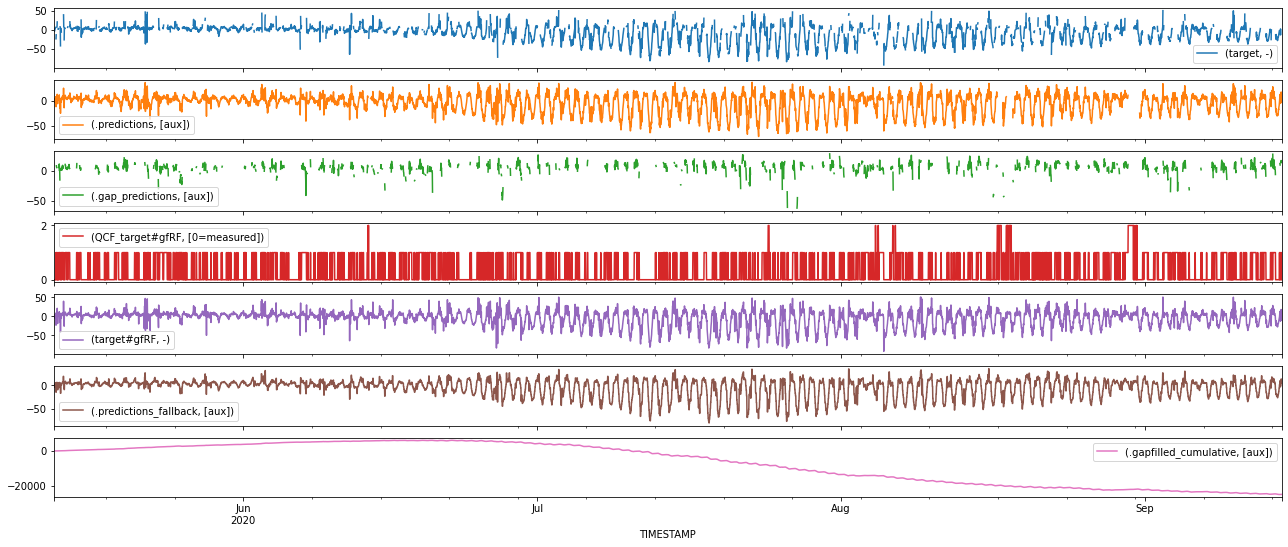

In [38]:
gapfilled_df.plot(subplots=True, figsize=(22, 9));

### Plot: Predictions vs. Target

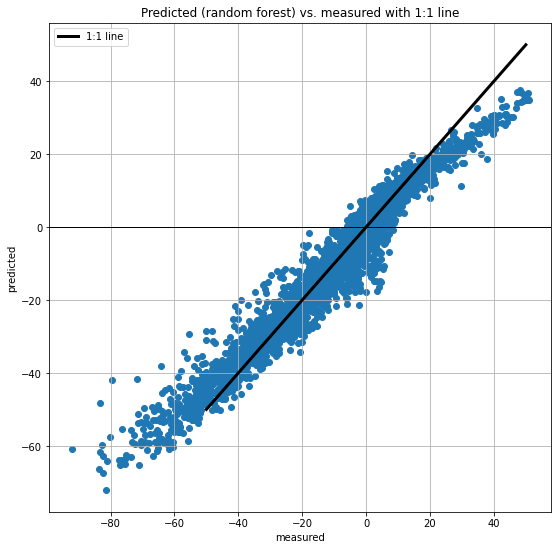

In [39]:
# Plot all targets vs. predictions
x_col = ('target', '-')
y_col = ('.predictions', '[aux]')
plt.figure(figsize=(9, 9))
plt.scatter(gapfilled_df[x_col], gapfilled_df[y_col])
plt.title("Predicted (random forest) vs. measured with 1:1 line")
plt.axhline(0, color='black', lw=1)
plt.plot([-50,50],[-50,50], 'black', linewidth=3, label="1:1 line", ls="-")
plt.xlabel("measured")
plt.ylabel("predicted")
# plt.xlim(-70, 20)
# plt.ylim(-70, 20)
plt.grid()
plt.legend();

### Plot: Measured And Gap-filled Values

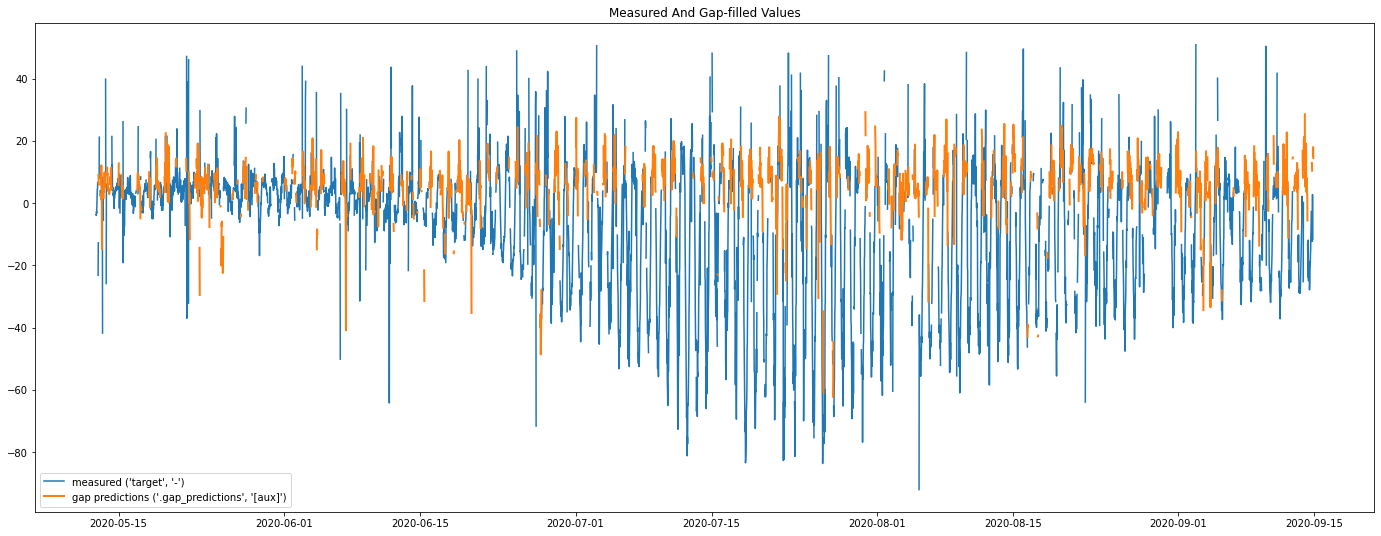

In [40]:
# Plot all targets and predictions
x_col = ('target', '-')
y_col = ('.gap_predictions', '[aux]')
plt.figure(figsize=(24, 9))
plt.title("Measured And Gap-filled Values")
plt.plot(gapfilled_df[x_col], label=f"measured {x_col}")
plt.plot(gapfilled_df[y_col], label=f"gap predictions {y_col}", lw=2)
plt.legend()
plt.show()

### Plot: Gap-filled Time Series

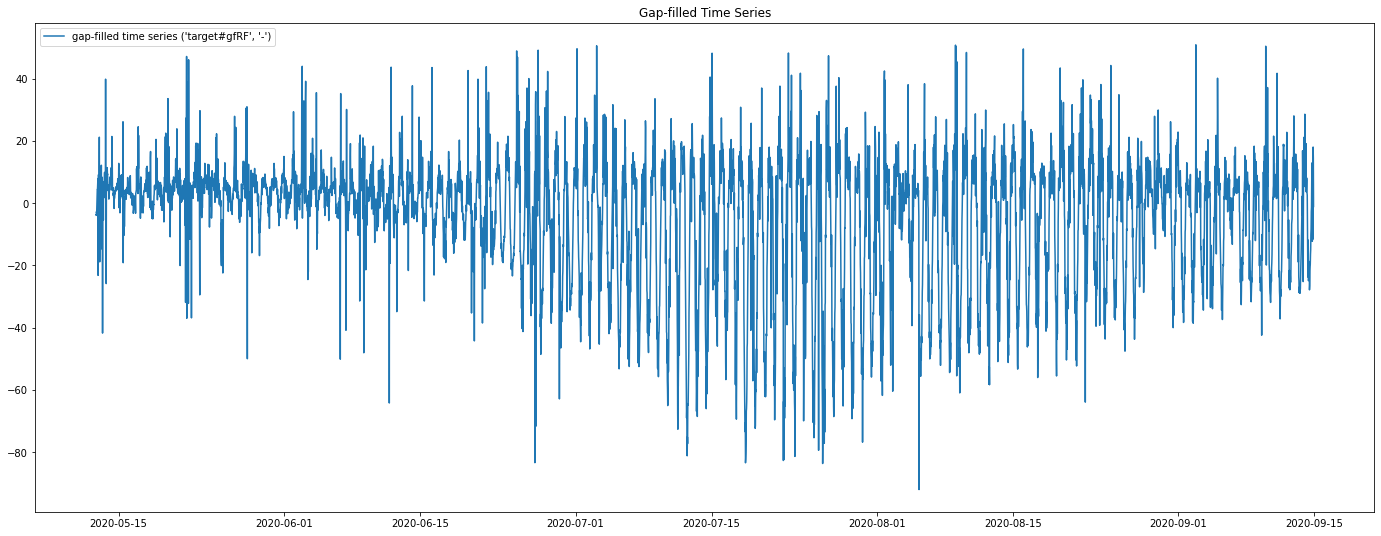

In [41]:
col = ('target#gfRF', '-')
plt.figure(figsize=(24, 9))
plt.title("Gap-filled Time Series")
plt.plot(gapfilled_df[col], label=f"gap-filled time series {col}")
plt.legend()
plt.show()

### Visualize tree

In [42]:
# # Visualize one of the decision trees
# from sklearn.tree import export_graphviz
# import pydot
# tree = rfts.model.estimators_[2]  # # Pull out one tree from the forest
# export_graphviz(tree, out_file = 'tree.dot', feature_names=rfts.feature_names, rounded = True, precision = 1)  # Export the image to a dot file
# (graph, ) = pydot.graph_from_dot_file('tree.dot')  # Use dot file to create a graph
# graph.write_png('tree.png')  # Write graph to a png file

In [43]:
# rfts.feat_reduction_results

## Kudos

- kudos: https://stackoverflow.com/questions/26911851/how-to-use-pandas-to-find-consecutive-same-data-in-time-series
- https://bambielli.com/til/2018-02-11-one-hot-encoding/
- https://www.educative.io/blog/one-hot-encoding#sklearn